## Covid-19 Geospatial Data Analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
from shapely.geometry import Point, Polygon

### Import Data

In [2]:
#location of Johns Hopkins University Data: https://github.com/CSSEGISandData/COVID-19

#Johns Hopkins Data on Cases and Deaths
cases_us_full = pd.read_csv('time_series_covid19_confirmed_US.csv')
deaths_us_full = pd.read_csv('time_series_covid19_deaths_US.csv')

#Data on population of each US county
pop_us = pd.read_csv('DECENNIALSF12010.P1_data_with_overlays_2021-12-03T213906.csv')

#CDC data on current vaccinations per US county
vac_us_full = pd.read_csv('COVID-19_Vaccinations_in_the_United_States_County.csv')

#County areas in sq miles
land_full=pd.read_excel('LND01.xls')


### Data Cleaning

In [3]:
cases_us_full.head(5)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,1/12/22,1/13/22,1/14/22,1/15/22,1/16/22,1/17/22,1/18/22,1/19/22,1/20/22,1/21/22
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,12180,12180,12180,12180,12624,12682,12738,12833,12928,13019
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,44353,44353,44353,44353,46528,46893,47143,47662,48338,49168
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,4437,4437,4437,4437,4684,4713,4741,4800,4843,4902
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,5046,5046,5046,5046,5274,5302,5385,5486,5565,5663
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,12068,12068,12068,12068,12520,12579,12648,12825,13005,13131


In [4]:
x=cases_us_full.columns.to_list()

In [5]:
#create new df of cases with only selected columns
cases_us = cases_us_full[[x[0],x[5],x[6],x[7],x[8],x[9],x[-1]]].copy()

#strip down UID column to get standard county ID for joining data from other df.
cases_us['ID'] = cases_us['UID'].astype(str).str[-5:]
#cases_us['ID'] = cases_us['ID'].astype(int)

In [6]:
cases_us = cases_us.rename(columns={'1/21/22':'Cases'})

In [7]:
df_us = cases_us.copy()

In [8]:
df_us['Deaths'] = deaths_us_full['1/21/22']

In [9]:
pop_us.head()

,GEO_ID,P001001,NAME
0,id,Total,Geographic Area Name
1,0500000US01001,54571,"Autauga County, Alabama"
2,0500000US01003,182265,"Baldwin County, Alabama"
3,0500000US01005,27457,"Barbour County, Alabama"
4,0500000US01007,22915,"Bibb County, Alabama"


In [10]:
pop_us=pop_us.drop([0])

In [11]:
pop_us=pop_us.rename(columns={'P001001':'Population'})

#strip down GEO_ID column to get standard county ID for joining data from other df.
pop_us['pop_ID']=pop_us['GEO_ID'].str[-5:]
#pop_us['pop_ID'] = pop_us['pop_ID'].astype(int)

In [12]:
#cleaning to remove the xxxx(rxxx) in the population column
pop_us['Population'].astype(str)
pattern = '\(......\)'
pop_us['Population']=pop_us.Population.str.replace(pat=pattern,repl= "", regex=True)
pop_us['Population'] = pop_us['Population'].astype(int)
#pop_us['pop_ID'] = pop_us['pop_ID'].astype(int)

In [13]:
#merge in population for each county to overall df
df_us=df_us.merge(pop_us[['Population','pop_ID']], how='left', left_on='ID', right_on='pop_ID')

In [14]:
vac_us_full = vac_us_full.rename(columns={'Administered_Dose1_Pop_Pct':'Vaccinated_Percent'})

In [15]:
#merge in vaccinated percent for each county to overall df
df_us = df_us.merge(vac_us_full, how='left', left_on='ID', right_on='FIPS')

In [16]:
df_us['Population'] = df_us['Population'].astype(float)

In [17]:
# create feature for cases as percent of county population
df_us['Cases_Percent']=((df_us['Cases']) / (df_us['Population']))*100

In [18]:
# create feature for deaths as percent of county population
df_us['Deaths_Percent']=((df_us['Deaths']) / (df_us['Population']))*100

In [19]:
df_us.shape

(3342, 15)

In [20]:
df_us = df_us.dropna()
df_us.shape

(3218, 15)

In [21]:
land_full.head()

,Areaname,STCOU,LND010190F,LND010190D,LND010190N1,LND010190N2,LND010200F,LND010200D,LND010200N1,LND010200N2,...,LND110210N1,LND110210N2,LND210190F,LND210190D,LND210190N1,LND210190N2,LND210200F,LND210200D,LND210200N1,LND210200N2
0,UNITED STATES,0,0,3787425.08,0,0,0,3794083.06,0,0,...,0,0,0,251083.35,0,0,0,256644.62,0,0
1,ALABAMA,1000,0,52422.94,0,0,0,52419.02,0,0,...,0,0,0,1672.71,0,0,0,1675.01,0,0
2,"Autauga, AL",1001,0,604.49,0,0,0,604.45,0,0,...,0,0,0,8.48,0,0,0,8.48,0,0
3,"Baldwin, AL",1003,0,2027.08,0,0,0,2026.93,0,0,...,0,0,0,430.55,0,0,0,430.58,0,0
4,"Barbour, AL",1005,0,904.59,0,0,0,904.52,0,0,...,0,0,0,19.59,0,0,0,19.61,0,0


In [22]:
#new df with only selected columns
land=land_full[['Areaname', 'STCOU', 'LND110210D']]
land.head()
#LND in sq miles

,Areaname,STCOU,LND110210D
0,UNITED STATES,0,3531905.43
1,ALABAMA,1000,50645.33
2,"Autauga, AL",1001,594.44
3,"Baldwin, AL",1003,1589.78
4,"Barbour, AL",1005,884.88


In [23]:
land['STCOU'] = land['STCOU'].astype(float)
df_us['ID'] = df_us['ID'].astype(float)

C:\Users\mvesc\AppData\Local\Temp/ipykernel_9736/4150547608.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  land['STCOU'] = land['STCOU'].astype(float)


In [24]:
#merge the land areas per county into the overall df 
df_us=df_us.merge(land, how='left', left_on='ID', right_on='STCOU')

In [25]:
#create feature for ppl/sq mi density
df_us['Pop_Density'] = (df_us['Population'])/(df_us['LND110210D'])

In [26]:
df_us.describe()

,UID,Lat,Long_,Cases,ID,Deaths,Population,Vaccinated_Percent,Cases_Percent,Deaths_Percent,STCOU,LND110210D,Pop_Density
count,3.218000e+03,3218.000000,3218.000000,3.218000e+03,3218.000000,3218.000000,3.218000e+03,3218.000000,3218.000000,3218.000000,3140.000000,3140.000000,3140.000000
mean,8.352239e+07,37.956602,-91.636082,2.153007e+04,31398.119640,263.968303,9.709262e+04,57.167775,20.763524,0.307595,30387.632484,1118.702166,259.278738
std,3.223699e+06,6.081417,13.331622,7.435139e+04,16286.924134,891.319024,3.094313e+05,15.793960,5.554595,0.148465,15156.372045,3601.799512,1724.871417
min,6.307200e+07,17.982429,-174.159600,0.000000e+00,1001.000000,0.000000,8.200000e+01,0.000000,0.000000,0.000000,1001.000000,2.000000,0.038404
25%,8.401806e+07,34.348720,-98.073681,2.166250e+03,19033.500000,32.000000,1.135250e+04,46.900000,17.700356,0.212002,18178.500000,430.737500,16.957902
50%,8.402910e+07,38.209070,-89.944637,5.351500e+03,30024.000000,80.000000,2.610850e+04,55.700000,20.979216,0.306168,29176.000000,615.595000,45.214209
75%,8.404504e+07,41.686672,-82.989554,1.395075e+04,46106.500000,192.000000,6.603225e+04,65.900000,23.893026,0.398629,45079.500000,923.557500,113.696677
max,8.405604e+07,69.314792,-65.288130,2.428744e+06,72153.000000,28346.000000,9.818605e+06,100.000000,95.121951,1.131542,56045.000000,145504.790000,69464.432764


In [27]:
pd.options.display.max_rows=250
df_us.sort_values(by='Pop_Density', ascending=False)

#Census Bureau defines divide between urban/rural as 1,000 ppl/sq mile

,UID,Admin2,Province_State,Country_Region,Lat,Long_,Cases,ID,Deaths,Population,pop_ID,FIPS,Vaccinated_Percent,Cases_Percent,Deaths_Percent,Areaname,STCOU,LND110210D,Pop_Density
1857,84036061,New York,New York,US,40.767273,-73.971526,379473,36061.0,5041,1585873.0,36061,36061,95.0,23.928335,0.317869,"New York, NY",36061.0,22.83,69464.432764
1850,84036047,Kings,New York,US,40.636182,-73.949356,651811,36047.0,11847,2504700.0,36047,36047,82.8,26.023516,0.472991,"Kings, NY",36047.0,70.82,35367.127930
1829,84036005,Bronx,New York,US,40.852093,-73.862828,389222,36005.0,7275,1385108.0,36005,36005,83.2,28.100480,0.525230,"Bronx, NY",36005.0,42.10,32900.427553
1867,84036081,Queens,New York,US,40.710881,-73.816847,607303,36081.0,11101,2230722.0,36081,36081,95.0,27.224504,0.497642,"Queens, NY",36081.0,108.53,20553.966645
222,84006075,San Francisco,California,US,37.752151,-122.438567,109859,6075.0,702,805235.0,06075,06075,94.1,13.643098,0.087180,"San Francisco, CA",6075.0,46.87,17180.179219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2383,63072145,Vega Baja,Puerto Rico,US,18.428262,-66.397924,8829,72145.0,0,59662.0,72145,72145,92.7,14.798364,0.000000,NaN,NaN,NaN,NaN
2384,63072147,Vieques,Puerto Rico,US,18.123276,-65.440971,538,72147.0,0,9301.0,72147,72147,85.3,5.784324,0.000000,NaN,NaN,NaN,NaN
2385,63072149,Villalba,Puerto Rico,US,18.127951,-66.473115,2559,72149.0,0,26073.0,72149,72149,95.0,9.814751,0.000000,NaN,NaN,NaN,NaN
2386,63072151,Yabucoa,Puerto Rico,US,18.070399,-65.896289,3589,72151.0,0,37941.0,72151,72151,83.9,9.459424,0.000000,NaN,NaN,NaN,NaN


In [28]:
#remove missing values for Puerto Rico
df_us=df_us.dropna(thresh=16)
df_us.shape

(3140, 19)

In [29]:
#Number of counties with 0 cases. Most likely these counties arent reporting. But cant exclude because we cant 
# say that for sure
df_us[df_us['Cases']==0].count()['Cases']

28

In [30]:
#Number of counties with 0 deaths. Most likely these counties arent reporting. But cant exclude because we cant 
# say that for sure
df_us[df_us['Deaths']==0].count()['Deaths']

49

### Exploratory Data Analysis / Descriptive Statistics

In [31]:
df_us.describe()

,UID,Lat,Long_,Cases,ID,Deaths,Population,Vaccinated_Percent,Cases_Percent,Deaths_Percent,STCOU,LND110210D,Pop_Density
count,3.140000e+03,3140.000000,3140.000000,3.140000e+03,3140.000000,3140.000000,3.140000e+03,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000
mean,8.403039e+07,38.446382,-92.262781,2.193158e+04,30387.632484,270.525478,9.831792e+04,56.479172,21.021128,0.315236,30387.632484,1118.702166,259.278738
std,1.515637e+04,5.291708,12.881550,7.521706e+04,15156.372045,901.341321,3.130385e+05,15.321976,5.363685,0.142056,15156.372045,3601.799512,1724.871417
min,8.400100e+07,19.601212,-174.159600,0.000000e+00,1001.000000,0.000000,8.200000e+01,0.000000,0.000000,0.000000,1001.000000,2.000000,0.038404
25%,8.401818e+07,34.692998,-98.218115,2.169250e+03,18178.500000,34.000000,1.111750e+04,46.700000,18.083722,0.221367,18178.500000,430.737500,16.957902
50%,8.402918e+07,38.370301,-90.392713,5.459000e+03,29176.000000,83.000000,2.589000e+04,55.400000,21.099505,0.309489,29176.000000,615.595000,45.214209
75%,8.404508e+07,41.796023,-83.436193,1.428650e+04,45079.500000,199.000000,6.689800e+04,65.100000,23.984028,0.401995,45079.500000,923.557500,113.696677
max,8.405604e+07,69.314792,-67.628135,2.428744e+06,56045.000000,28346.000000,9.818605e+06,100.000000,95.121951,1.131542,56045.000000,145504.790000,69464.432764


<AxesSubplot:xlabel='Cases_Percent', ylabel='Count'>

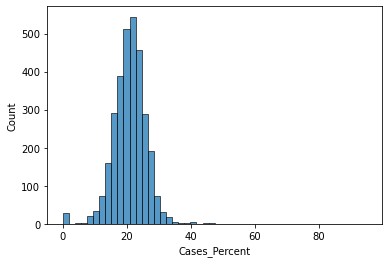

In [32]:
#Figure 1
sns.histplot(data=df_us, x='Cases_Percent', bins=50)

<AxesSubplot:xlabel='Deaths_Percent', ylabel='Count'>

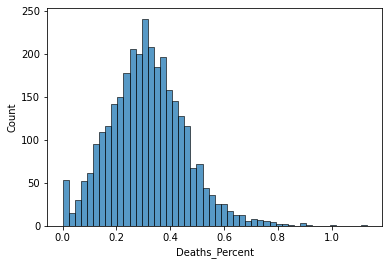

In [33]:
#Figure 2
sns.histplot(data=df_us, x='Deaths_Percent', bins=50)

<AxesSubplot:xlabel='Vaccinated_Percent', ylabel='Count'>

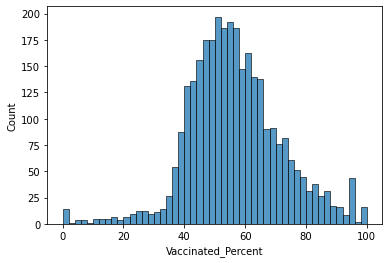

In [34]:
#Figure 3
sns.histplot(data=df_us, x='Vaccinated_Percent', bins=50)

<AxesSubplot:xlabel='Pop_Density', ylabel='Count'>

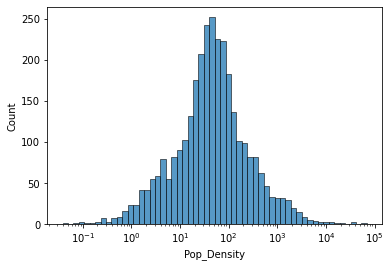

In [35]:
#Figure 4
sns.histplot(data=df_us, x='Pop_Density', bins='auto', log_scale=True)
#log scale

Cases and Death Percentages were very normally distributed aside from counties that are believed to not be reporting. The Vaccinated Percentage was not as normally distributed as compared to Cases and Death Percentage histograms. 

Is there a difference in Cases and Deaths Percentages based upon population density?
3 different population densities will be used to determine any differences. 
1) > 1000 people/sq mi

2) > 100 & < 1000 people/sq mi

3) < 100 people/sq mi

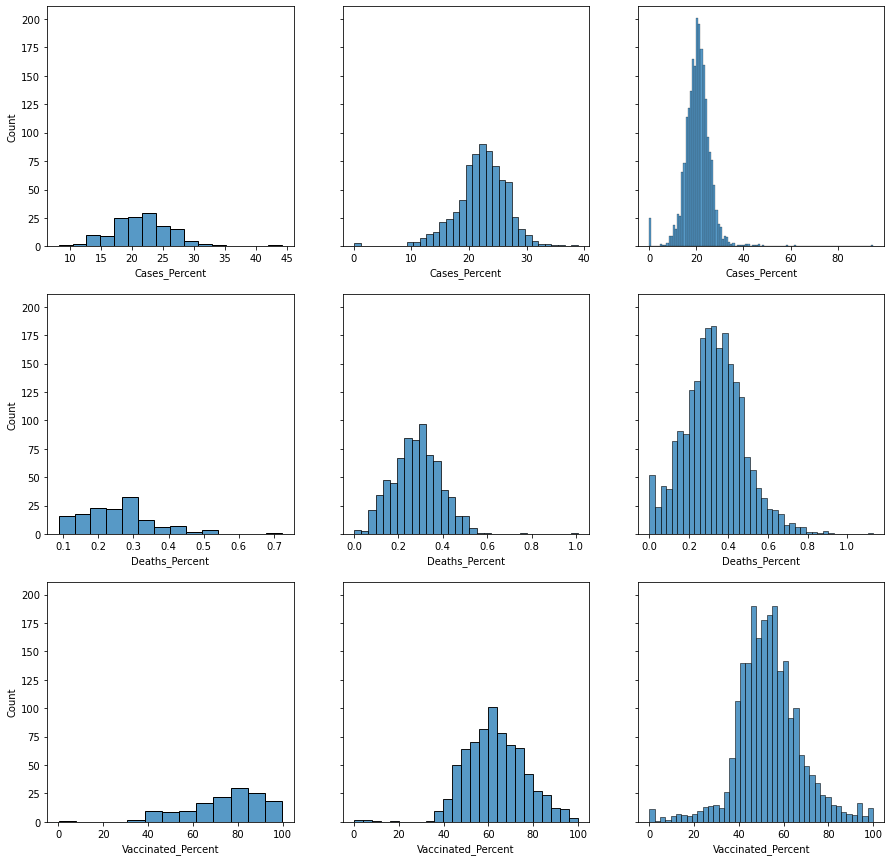

In [36]:
#Figure 5


#break the pop density into 3 cohorts based upon population densities, and see if there are more differences

fig, axes = plt.subplots(3,3, figsize=(15,15), sharey=True)


Filt_urban2 = df_us[df_us['Pop_Density'] > 1000]
Filt_middle2 = df_us[(df_us['Pop_Density'] > 100) & (df_us['Pop_Density'] <= 1000)]
Filt_rural2 = df_us[df_us['Pop_Density'] <= 100]

sns.histplot(ax=axes[0,0], data=Filt_urban2, x='Cases_Percent', bins='auto')
sns.histplot(ax=axes[0,1], data=Filt_middle2, x='Cases_Percent', bins='auto')
sns.histplot(ax=axes[0,2], data=Filt_rural2, x='Cases_Percent', bins='auto')

sns.histplot(ax=axes[1,0], data=Filt_urban2, x='Deaths_Percent', bins='auto')
sns.histplot(ax=axes[1,1], data=Filt_middle2, x='Deaths_Percent', bins='auto')
sns.histplot(ax=axes[1,2], data=Filt_rural2, x='Deaths_Percent', bins='auto')

sns.histplot(ax=axes[2,0], data=Filt_urban2, x='Vaccinated_Percent', bins='auto')
sns.histplot(ax=axes[2,1], data=Filt_middle2, x='Vaccinated_Percent', bins='auto')
sns.histplot(ax=axes[2,2], data=Filt_rural2, x='Vaccinated_Percent', bins='auto')

plt.show()

In [37]:
#Table 1
Filt_urban2.describe()[['Vaccinated_Percent', 'Cases_Percent', 'Deaths_Percent', 'Pop_Density']]

,Vaccinated_Percent,Cases_Percent,Deaths_Percent,Pop_Density
count,144.000000,144.000000,144.000000,144.000000
mean,73.529167,21.615400,0.258944,3669.257080
std,17.061493,4.909444,0.107013,7250.614747
min,0.100000,8.180811,0.087180,1002.911717
25%,65.250000,18.814172,0.184283,1337.394876
50%,77.150000,21.631920,0.261780,1757.211043
75%,86.725000,24.751202,0.307570,2810.141447
max,99.900000,44.278782,0.723537,69464.432764


In [38]:
#Table 2
Filt_middle2.describe()[['Vaccinated_Percent', 'Cases_Percent', 'Deaths_Percent', 'Pop_Density']]

,Vaccinated_Percent,Cases_Percent,Deaths_Percent,Pop_Density
count,734.000000,734.000000,734.000000,734.000000
mean,63.010490,22.194095,0.283646,286.464595
std,13.607279,4.449979,0.110787,200.223601
min,0.000000,0.000000,0.000000,100.032720
25%,53.925000,19.771406,0.204727,136.609525
50%,62.500000,22.418238,0.284295,212.203346
75%,71.975000,25.016746,0.354747,369.585729
max,99.900000,38.895361,1.008236,996.692668


In [39]:
#Table 3
Filt_rural2.describe()[['Vaccinated_Percent', 'Cases_Percent', 'Deaths_Percent', 'Pop_Density']]

,Vaccinated_Percent,Cases_Percent,Deaths_Percent,Pop_Density
count,2262.000000,2262.000000,2262.000000,2262.000000
mean,53.274403,20.602679,0.329071,33.376306
std,14.312637,5.599318,0.150319,26.558593
min,0.000000,0.000000,0.000000,0.038404
25%,45.000000,17.535018,0.232283,9.962638
50%,52.600000,20.631940,0.325952,27.954589
75%,60.975000,23.499009,0.421642,50.694629
max,100.000000,95.121951,1.131542,99.861149


Result: All 3 cohorts showed very normally distributed data in Cases Percent and Deaths Percent. Cases Percent median for all 3 cohorts was within +/- 1% of 21.5% with no pattern based upon population density. Deaths Percent median for a 3 cohorts was within +/- 2.5% of 28.5%, and the Death Percent increased as the population density decreased. 

Data for Vaccinated Percent was normally distributed but retained some skew for the most urban cohort and most rural cohort. A drill down into the highly vaccinated urban counties (upper 25% quartile) and lowest vaccinated rural counties (34% and lower) will be performed for further insights.

In [40]:
Filt_urban3 = Filt_urban2[Filt_urban2['Vaccinated_Percent']>86.725]

In [41]:
Filt_rural3 = Filt_rural2[Filt_rural2['Vaccinated_Percent']<34.00]

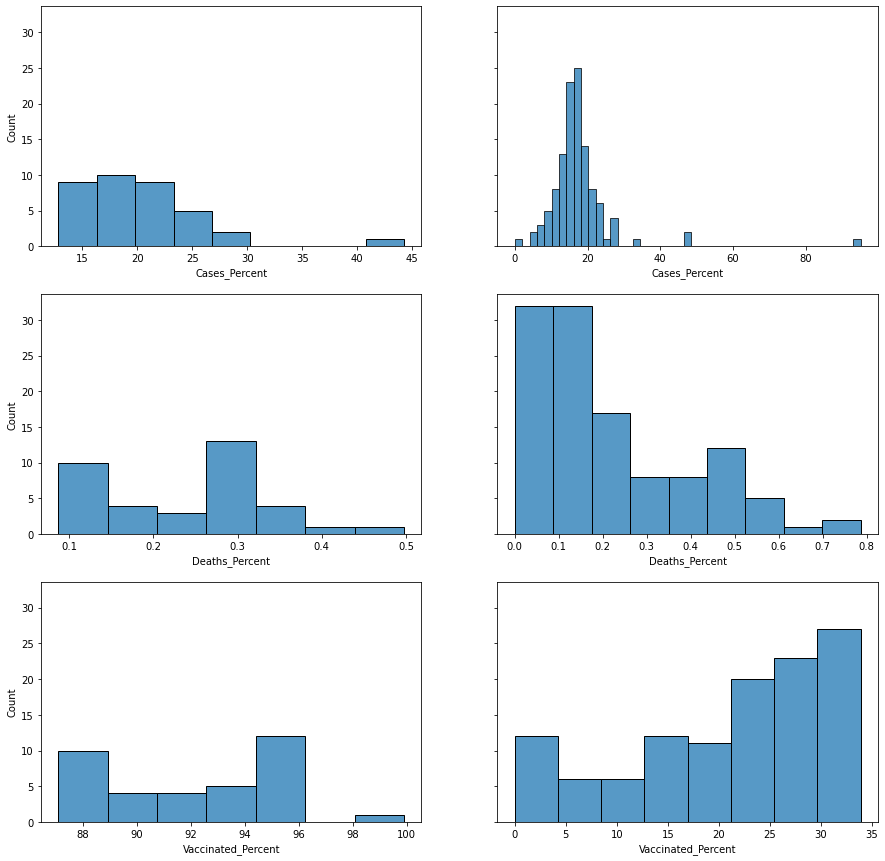

In [42]:
#Figure 6

fig, axes = plt.subplots(3,2, figsize=(15,15), sharey=True)

sns.histplot(ax=axes[0,0], data=Filt_urban3, x='Cases_Percent', bins='auto')
sns.histplot(ax=axes[0,1], data=Filt_rural3, x='Cases_Percent', bins='auto')

sns.histplot(ax=axes[1,0], data=Filt_urban3, x='Deaths_Percent', bins='auto')
sns.histplot(ax=axes[1,1], data=Filt_rural3, x='Deaths_Percent', bins='auto')

sns.histplot(ax=axes[2,0], data=Filt_urban3, x='Vaccinated_Percent', bins='auto')
sns.histplot(ax=axes[2,1], data=Filt_rural3, x='Vaccinated_Percent', bins='auto')

plt.show()

In [43]:
#Table 4
Filt_urban3.describe()[['Vaccinated_Percent', 'Cases_Percent', 'Deaths_Percent', 'Pop_Density']]

,Vaccinated_Percent,Cases_Percent,Deaths_Percent,Pop_Density
count,36.000000,36.000000,36.000000,36.000000
mean,91.936111,20.340480,0.236522,5642.190540
std,3.290172,5.850491,0.101269,11945.675645
min,87.100000,12.805473,0.087180,1012.535852
25%,88.775000,16.983757,0.135269,1364.631018
50%,92.400000,19.451643,0.267289,1699.259930
75%,95.000000,22.954343,0.296181,3251.542821
max,99.900000,44.278782,0.497642,69464.432764


In [44]:
#Table 5
Filt_rural3.describe()[['Vaccinated_Percent', 'Cases_Percent', 'Deaths_Percent', 'Pop_Density']]

,Vaccinated_Percent,Cases_Percent,Deaths_Percent,Pop_Density
count,117.000000,117.000000,117.000000,117.000000
mean,20.935043,17.510491,0.214562,14.546517
std,10.190169,9.628235,0.182737,19.248918
min,0.000000,0.000000,0.000000,0.122584
25%,14.200000,14.060032,0.085160,1.591429
50%,23.900000,16.513761,0.165344,6.895832
75%,29.200000,19.076427,0.322061,16.806661
max,33.900000,95.121951,0.786627,97.803066


Results: Table 4 shows the upper 25% quartile of Vaccinated Percent of urban areas had a slightly higher median Deaths Percent but a much lower Cases Percent when compared to the overall urban areas population density. 

Table 5 shows the lowest vaccinated rural areas, a median rate of 23.9% vaccinated. The Cases Percent and Deaths Percent median were 16.5% and 0.17%, respectively. The Deaths Percent data was skewed, and the mean was 0.21%. Surprisingly, this lowely vaccinated area has a lower Death Percent than even the most highly vaccinated urban area. Another factor to consider is Population Density associated with Table 5. The median population density for this group is 7 people per square mile. The general lack of humans to pass on the infection should be a consideration in this analysis.

## Correlation and Cluster Analysis

### What are the correlations, if any, between vaccination, cases, deaths, and population density?

In [45]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [46]:
df_us.head()

,UID,Admin2,Province_State,Country_Region,Lat,Long_,Cases,ID,Deaths,Population,pop_ID,FIPS,Vaccinated_Percent,Cases_Percent,Deaths_Percent,Areaname,STCOU,LND110210D,Pop_Density
0,84001001,Autauga,Alabama,US,32.539527,-86.644082,13019,1001.0,163,54571.0,01001,01001,53.7,23.856994,0.298693,"Autauga, AL",1001.0,594.44,91.802369
1,84001003,Baldwin,Alabama,US,30.727750,-87.722071,49168,1003.0,608,182265.0,01003,01003,62.8,26.976106,0.333580,"Baldwin, AL",1003.0,1589.78,114.647939
2,84001005,Barbour,Alabama,US,31.868263,-85.387129,4902,1005.0,83,27457.0,01005,01005,53.8,17.853371,0.302291,"Barbour, AL",1005.0,884.88,31.029066
3,84001007,Bibb,Alabama,US,32.996421,-87.125115,5663,1007.0,95,22915.0,01007,01007,41.6,24.713070,0.414576,"Bibb, AL",1007.0,622.58,36.806515
4,84001009,Blount,Alabama,US,33.982109,-86.567906,13131,1009.0,204,57322.0,01009,01009,37.4,22.907435,0.355884,"Blount, AL",1009.0,644.78,88.901641


In [47]:
df_clust = df_us[['Vaccinated_Percent', 'Cases_Percent', 'Deaths_Percent', 'Pop_Density']]
df_clust

,Vaccinated_Percent,Cases_Percent,Deaths_Percent,Pop_Density
0,53.7,23.856994,0.298693,91.802369
1,62.8,26.976106,0.333580,114.647939
2,53.8,17.853371,0.302291,31.029066
3,41.6,24.713070,0.414576,36.806515
4,37.4,22.907435,0.355884,88.901641
...,...,...,...,...
3213,56.8,21.570105,0.260238,4.201349
3214,98.9,41.391941,0.065746,5.329656
3215,57.5,23.330808,0.161000,10.146738
3216,46.0,23.731396,0.480488,3.811842


In [48]:
scaler = StandardScaler()
df_stand = scaler.fit_transform(df_clust)

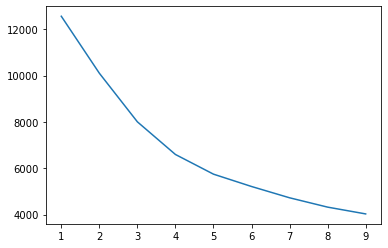

In [49]:
wcss=[]
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state = 20)
    kmeans.fit(df_stand)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,10),wcss)
plt.show()

In [50]:
#select number of clusters as 5
kmeans = KMeans(n_clusters=5, init = 'k-means++', random_state = 20)
y_kmeans = kmeans.fit_predict(df_stand)

In [51]:
df_clust['cluster_number'] = y_kmeans
df_us['cluster_number'] = y_kmeans

C:\Users\mvesc\AppData\Local\Temp/ipykernel_9736/1981006699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust['cluster_number'] = y_kmeans


In [52]:
#Table 6
#show how many data points assigned to each cluster
df_clust.groupby(by='cluster_number').count()

,Vaccinated_Percent,Cases_Percent,Deaths_Percent,Pop_Density
cluster_number,,,,
0,629,629,629,629
1,916,916,916,916
2,546,546,546,546
3,3,3,3,3
4,1046,1046,1046,1046


<AxesSubplot:>

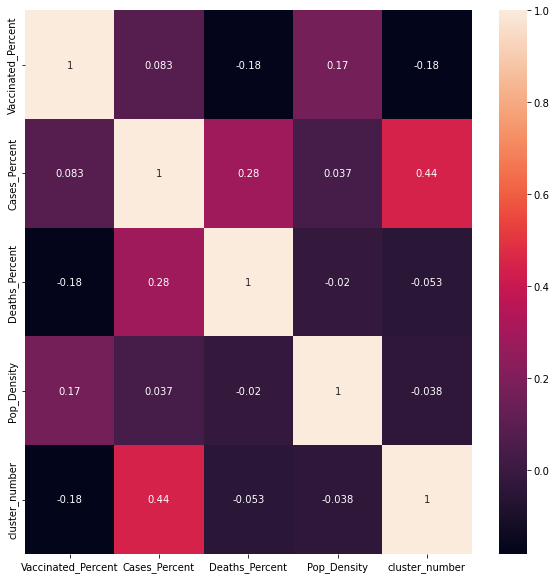

In [53]:
#Figure 7

plt.figure(figsize=(10,10))
sns.heatmap(data=df_clust.corr(), annot=True)

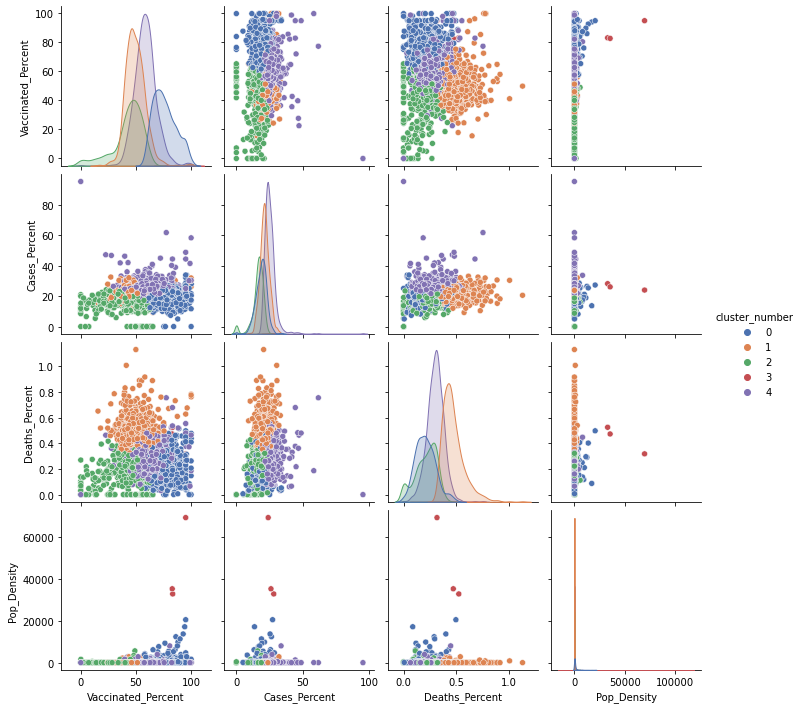

In [54]:
# Figure 8
sns.pairplot(data=df_clust, hue='cluster_number', palette='deep')

<AxesSubplot:xlabel='Deaths_Percent', ylabel='Cases_Percent'>

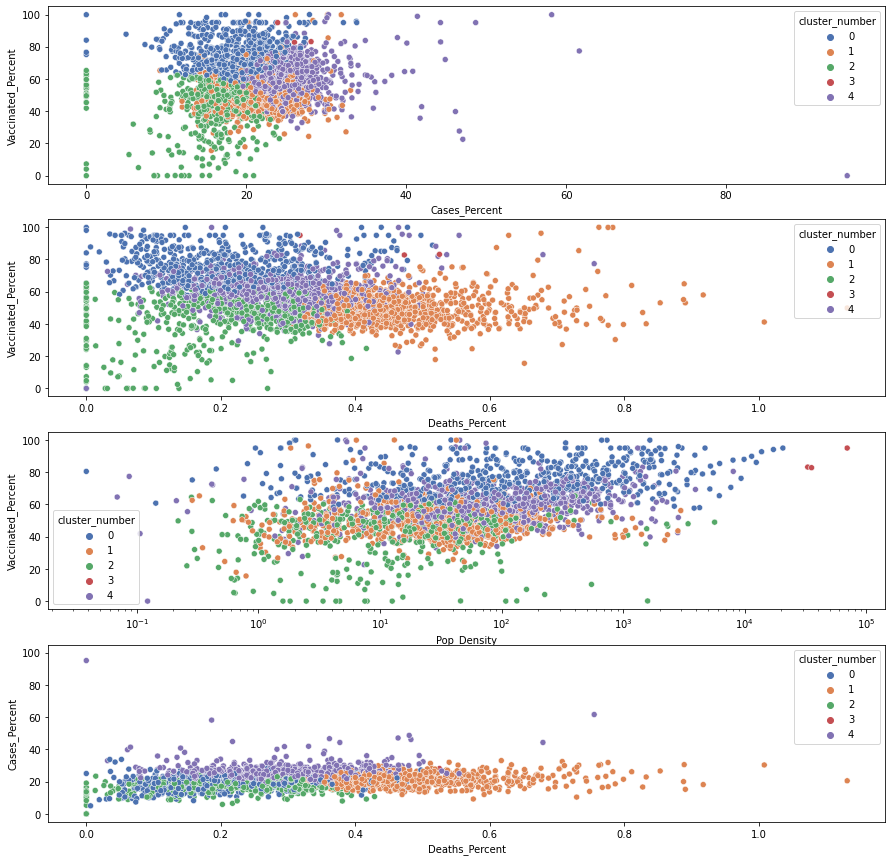

In [55]:
#Figure 9

fig, axes = plt.subplots(4, figsize=(15,15), sharey=True)

sns.scatterplot(ax=axes[0], data=df_us, hue='cluster_number', x='Cases_Percent', y='Vaccinated_Percent', palette='deep')
sns.scatterplot(ax=axes[1], data=df_us, hue='cluster_number', x='Deaths_Percent', y='Vaccinated_Percent', palette='deep')
axes[2].set(xscale='log')
sns.scatterplot(ax=axes[2], data=df_us, hue='cluster_number', x='Pop_Density', y='Vaccinated_Percent', palette='deep')
sns.scatterplot(ax=axes[3], data=df_us, hue='cluster_number', x='Deaths_Percent', y='Cases_Percent', palette='deep')

In [56]:
#Table 7

for i in range(0,5):
    print(df_clust[df_clust['cluster_number']==i].describe()[['Vaccinated_Percent', 'Cases_Percent', 'Deaths_Percent', 'Pop_Density']])

       Vaccinated_Percent  Cases_Percent  Deaths_Percent   Pop_Density
count          629.000000     629.000000      629.000000    629.000000
mean            75.738474      18.493430        0.206654    616.077918
std             10.065623       4.179649        0.095158   1712.203182
min             57.700000       0.000000        0.000000      0.038404
25%             67.600000      15.874528        0.137747     31.925652
50%             74.100000      18.900695        0.200959    102.059143
75%             82.700000      21.181696        0.268332    431.573351
max            100.000000      33.806849        0.514879  20553.966645
       Vaccinated_Percent  Cases_Percent  Deaths_Percent  Pop_Density
count          916.000000     916.000000      916.000000   916.000000
mean            49.323581      21.122333        0.469894    74.201115
std              9.248990       3.424109        0.103532   207.553193
min             15.600000       9.208633        0.307554     0.285258
25%        

In [57]:
#Table 8

for i in range(0,5):
    print(df_clust[df_clust['cluster_number']==i].median()[['Vaccinated_Percent', 'Cases_Percent', 'Deaths_Percent', 'Pop_Density']])

Vaccinated_Percent     74.100000
Cases_Percent          18.900695
Deaths_Percent          0.200959
Pop_Density           102.059143
dtype: float64
Vaccinated_Percent    48.500000
Cases_Percent         21.006309
Deaths_Percent         0.447603
Pop_Density           34.466292
dtype: float64
Vaccinated_Percent    45.600000
Cases_Percent         16.734780
Deaths_Percent         0.224715
Pop_Density           17.421042
dtype: float64
Vaccinated_Percent       83.200000
Cases_Percent            26.023516
Deaths_Percent            0.472991
Pop_Density           35367.127930
dtype: float64
Vaccinated_Percent    58.000000
Cases_Percent         24.295775
Deaths_Percent         0.302838
Pop_Density           64.405746
dtype: float64


### Results: 

Cluster Number had the strongest correlation to Cases Percent as shown in Figure 7. Therefore, Cases Percent was the most important factor in determining Cluster Number. Population Density had almost no correlation to anything except Vaccinated Percent. It was surprising that Population Density did not correlate to Cases Percent because it was expected a high population density would make it harder to not be amongst other people, and thus more likely to become infected. Aside from cluster number, the next strongest correlation was Cases Percent vs Death Percent which was an expected correlation.

Cluster 3 contained only 3 points as shown in Table 6. Those 3 points were also the largest population densities. This is too small of sample size to draw conclusions.

The Cases Percent and Deaths Percent standard deviation amongst all the clusters was very similar. The Vaccination Percent standard deviation amonst all the clusters was not as consistant as shown in Table 7.

The clusters can be approximately described as such from the clusters' medians in Table 8:

Cluster 0: high vaccination, low cases, low deaths, mid to high population density, 629 data points

Cluster 1: low vaccination, mid cases, high deaths, low to mid population density, 916 data points 

Cluster 2: low vaccination, low cases, low deaths, low population density, 546 data points

Cluster 3: high vaccination, high cases, high deaths, high population density, 3 data points

Cluster 4: mid vaccination, high cases, mid deaths, mid population density, 1046 data points 

## Geospatial Analysis

### How do the cluster location look when plotted on a map? Are there any additional correlations that can be found?

In [58]:
df_us.head()

,UID,Admin2,Province_State,Country_Region,Lat,Long_,Cases,ID,Deaths,Population,pop_ID,FIPS,Vaccinated_Percent,Cases_Percent,Deaths_Percent,Areaname,STCOU,LND110210D,Pop_Density,cluster_number
0,84001001,Autauga,Alabama,US,32.539527,-86.644082,13019,1001.0,163,54571.0,01001,01001,53.7,23.856994,0.298693,"Autauga, AL",1001.0,594.44,91.802369,4
1,84001003,Baldwin,Alabama,US,30.727750,-87.722071,49168,1003.0,608,182265.0,01003,01003,62.8,26.976106,0.333580,"Baldwin, AL",1003.0,1589.78,114.647939,4
2,84001005,Barbour,Alabama,US,31.868263,-85.387129,4902,1005.0,83,27457.0,01005,01005,53.8,17.853371,0.302291,"Barbour, AL",1005.0,884.88,31.029066,2
3,84001007,Bibb,Alabama,US,32.996421,-87.125115,5663,1007.0,95,22915.0,01007,01007,41.6,24.713070,0.414576,"Bibb, AL",1007.0,622.58,36.806515,1
4,84001009,Blount,Alabama,US,33.982109,-86.567906,13131,1009.0,204,57322.0,01009,01009,37.4,22.907435,0.355884,"Blount, AL",1009.0,644.78,88.901641,1


In [59]:
#read in US county shape file
county_shp = gpd.read_file('.\cb_2018_us_county_500k\cb_2018_us_county_500k.shp')

In [60]:
# merge county shape geometry into df_us to make required geometry for geodataframe 
df_us = df_us.merge(county_shp[['geometry', 'GEOID']], how='left', left_on='pop_ID', right_on='GEOID')

In [61]:
#create geodataframe
geo_df = gpd.GeoDataFrame(df_us, crs=4326, geometry=df_us['geometry'])

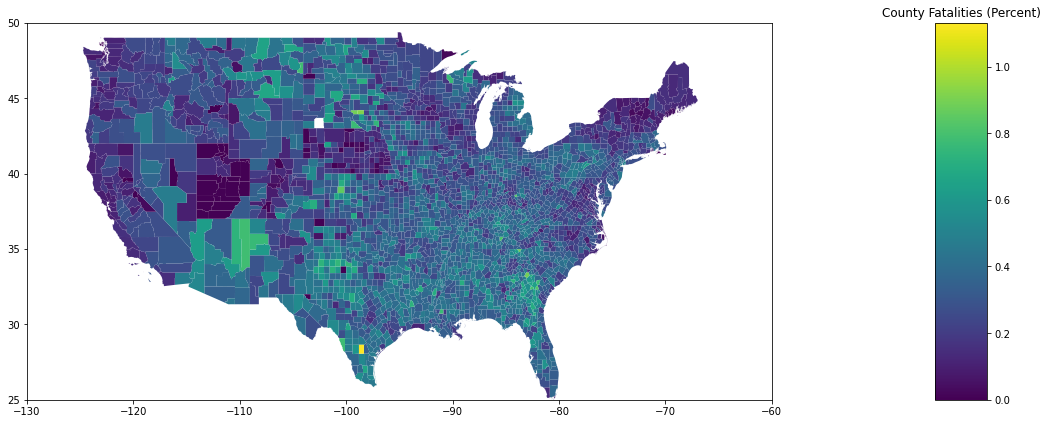

In [62]:
# Figure 10

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,1, figsize=(20,20))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
ax.set_xlim(-130,-60)
ax.set_ylim(25,50)
plt.title('County Fatalities (Percent)', loc='center')

geo_df.plot(ax=ax, column='Deaths_Percent', legend=True, cax=cax)

plt.show()

In [63]:
# Figure 11

#geo_df.explore(legend=True, column='Vaccinated_Percent', tooltip=['Cases_Percent', 'Cases', 'Deaths_Percent', 'Deaths', 'Vaccinated_Percent', 'Areaname', 'Population'])
# uncomment line above to display interactive folium map. File size becomes too large to upload to github if the map is displayed

In [66]:
# Figure 12

#m = geo_df[geo_df['cluster_number']==0].explore(color='blue', tooltip=['cluster_number', 'Cases_Percent', 'Cases', 'Deaths_Percent', 'Deaths', 'Vaccinated_Percent', 'Areaname', 'Population'])
#geo_df[geo_df['cluster_number']==1].explore(m=m, color='orange', tooltip=['cluster_number', 'Cases_Percent', 'Cases', 'Deaths_Percent', 'Deaths', 'Vaccinated_Percent', 'Areaname', 'Population'])
#geo_df[geo_df['cluster_number']==2].explore(m=m, color='green', tooltip=['cluster_number', 'Cases_Percent', 'Cases', 'Deaths_Percent', 'Deaths', 'Vaccinated_Percent', 'Areaname', 'Population'])
#geo_df[geo_df['cluster_number']==3].explore(m=m, color='red', tooltip=['cluster_number', 'Cases_Percent', 'Cases', 'Deaths_Percent', 'Deaths', 'Vaccinated_Percent', 'Areaname', 'Population'])
#geo_df[geo_df['cluster_number']==4].explore(m=m, color='purple', tooltip=['cluster_number', 'Cases_Percent', 'Cases', 'Deaths_Percent', 'Deaths', 'Vaccinated_Percent', 'Areaname', 'Population'])

#m
# uncomment lines above to display interactive folium map. File size becomes too large to upload to github if the map is displayed

### Results:

Cluster 3 (red) all 3 data points are located in New York City.

Cluster 2 (green) had the lowest median population density. That makes sense when the majority of its data points are in the west.

Cluster 0 (blue) is predominantly found on the west coast or the northeast.

Clusters 1 (orange) and 4 (purple) are predominantly in the south and midwest.

In [65]:
#https://covid.cdc.gov/covid-data-tracker/#county-view?list_select_state=all_states&list_select_county=all_counties&data-type=Vaccinations&metric=Administered_Dose1_Pop_Pct
# https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh/data
